# 0. Load Files

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df = pd.read_parquet('../data/df_cleaned_for_classification_models.parquet')
df.head() 

,IncidentGroup_Fire,IncidentGroup_Special Service,AggregatedPropertyCategory_Outdoor,AggregatedPropertyCategory_Residential,AggregatedPropertyCategory_Vehicle,CellEastingNorthing2500_502500-175000,CellEastingNorthing2500_502500-177500,CellEastingNorthing2500_502500-180000,CellEastingNorthing2500_502500-182500,CellEastingNorthing2500_502500-187500,CellEastingNorthing2500_502500-190000,CellEastingNorthing2500_502500-192500,CellEastingNorthing2500_505000-172500,CellEastingNorthing2500_505000-175000,CellEastingNorthing2500_505000-177500,CellEastingNorthing2500_505000-180000,CellEastingNorthing2500_505000-182500,CellEastingNorthing2500_505000-185000,CellEastingNorthing2500_505000-187500,CellEastingNorthing2500_505000-190000,CellEastingNorthing2500_507500-170000,CellEastingNorthing2500_507500-172500,CellEastingNorthing2500_507500-175000,CellEastingNorthing2500_507500-177500,CellEastingNorthing2500_507500-180000,CellEastingNorthing2500_507500-182500,CellEastingNorthing2500_507500-185000,CellEastingNorthing2500_507500-187500,CellEastingNorthing2500_507500-190000,CellEastingNorthing2500_510000-167500,CellEastingNorthing2500_510000-170000,CellEastingNorthing2500_510000-172500,CellEastingNorthing2500_510000-175000,CellEastingNorthing2500_510000-177500,CellEastingNorthing2500_510000-180000,CellEastingNorthing2500_510000-182500,CellEastingNorthing2500_510000-185000,CellEastingNorthing2500_510000-187500,CellEastingNorthing2500_510000-190000,CellEastingNorthing2500_512500-167500,CellEastingNorthing2500_512500-170000,CellEastingNorthing2500_512500-172500,CellEastingNorthing2500_512500-175000,CellEastingNorthing2500_512500-177500,CellEastingNorthing2500_512500-180000,CellEastingNorthing2500_512500-182500,CellEastingNorthing2500_512500-185000,CellEastingNorthing2500_512500-187500,CellEastingNorthing2500_512500-190000,CellEastingNorthing2500_512500-192500,CellEastingNorthing2500_515000-157500,CellEastingNorthing2500_515000-160000,CellEastingNorthing2500_515000-162500,CellEastingNorthing2500_515000-165000,CellEastingNorthing2500_515000-167500,CellEastingNorthing2500_515000-170000,CellEastingNorthing2500_515000-172500,CellEastingNorthing2500_515000-175000,CellEastingNorthing2500_515000-177500,CellEastingNorthing2500_515000-180000,CellEastingNorthing2500_515000-182500,CellEastingNorthing2500_515000-185000,CellEastingNorthing2500_515000-187500,CellEastingNorthing2500_515000-190000,CellEastingNorthing2500_515000-192500,CellEastingNorthing2500_517500-160000,CellEastingNorthing2500_517500-162500,CellEastingNorthing2500_517500-165000,CellEastingNorthing2500_517500-167500,CellEastingNorthing2500_517500-170000,CellEastingNorthing2500_517500-172500,CellEastingNorthing2500_517500-175000,CellEastingNorthing2500_517500-177500,CellEastingNorthing2500_517500-180000,CellEastingNorthing2500_517500-182500,CellEastingNorthing2500_517500-185000,CellEastingNorthing2500_517500-187500,CellEastingNorthing2500_517500-190000,CellEastingNorthing2500_517500-192500,CellEastingNorthing2500_517500-195000,CellEastingNorthing2500_520000-162500,CellEastingNorthing2500_520000-165000,CellEastingNorthing2500_520000-167500,CellEastingNorthing2500_520000-170000,CellEastingNorthing2500_520000-172500,CellEastingNorthing2500_520000-175000,CellEastingNorthing2500_520000-177500,CellEastingNorthing2500_520000-180000,CellEastingNorthing2500_520000-182500,CellEastingNorthing2500_520000-185000,CellEastingNorthing2500_520000-187500,CellEastingNorthing2500_520000-190000,CellEastingNorthing2500_520000-192500,CellEastingNorthing2500_520000-195000,CellEastingNorthing2500_522500-160000,CellEastingNorthing2500_522500-162500,CellEastingNorthing2500_522500-165000,CellEastingNorthing2500_522500-167500,CellEastingNorthing2500_522500-170000,CellEastingNorthing2500_522500-172500,CellEastingNorthing2500_522500-175000,CellEastingNorthing2500_522500-177500,CellEastingNorthing2500_522500-180000,CellEastingNorthing2500_522500-182500,CellEastingNorthing2500_522500-185000,CellEastingNorthing2500_522500-187500,Cel

# 1. PCA Transformation & Balancing Data Set

In [14]:
X = df.drop("ResponseTimeBinary", axis = 1)
y = df["ResponseTimeBinary"]

In [15]:
pca = PCA(n_components=0.85)
X = pca.fit_transform(X)

In [16]:
rUs = RandomUnderSampler(random_state=666)
X, y = rUs.fit_resample(X, y)
print('Sample classes undersampled :', dict(pd.Series(y).value_counts()))

Sample classes undersampled : {0: 451697, 1: 451697}


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 666)

# 2. Voting Classifier

## 2.1 Instantiating XGBoost, RF, & LogReg Models

In [18]:
xgboost = xgb.XGBClassifier(random_state=666)
rf = RandomForestClassifier(random_state=666)
logreg = LogisticRegression(random_state=666)

## 2.3 Cross Validation via  GridSearchCV

In [19]:
params_xgboost = {
    'XGboost__learning_rate': [0.1],
    'XGboost__max_depth': [5],
    'XGboost__n_estimators': [200],
    'XGboost__subsample': [0.9]
}
params_rf = {
    'RF__criterion': ['gini'],
    'RF__max_depth': [10],
    'RF__n_estimators': [200]
}
params_logreg = {
    'LogReg__C': [5],
    'LogReg__penalty': ['l2'],
    'LogReg__solver': ['lbfgs']
}

# Combine parameters into a single dictionary
params = {**params_xgboost, **params_rf, **params_logreg}

## 2.4 Model Evaluation (Voting Classifier (Soft))

In [20]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, balanced_accuracy_score

def evaluate_model(y_true, y_pred, y_proba = None):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n', cm)
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    
    # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print('Classification Report:\n', classification_report(y_true, y_pred, target_names=['Not Reached (>6 min)', 'Reached (<=6 min)']))
    
    # ROC AUC Score
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba[:, 1])
        print(f'ROC AUC Score: {roc_auc:.4f}')
    else:
        roc_auc = None
    
    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    print(f'Balanced Accuracy: {balanced_acc:.4f}')
    
    return accuracy, precision, recall, f1, roc_auc, balanced_acc

## 2.5 Instantiating Voting Classifier (Hard)

In [14]:
vclf_hard = VotingClassifier(estimators=[('XGboost', xgboost), ('RF', rf), ('LogReg', logreg)], voting='hard')

## 2.6 Cross Validation via  GridSearchCV

In [15]:
model = GridSearchCV(estimator=vclf_hard, param_grid=params, cv=5)
model.fit(X_ru, y_ru)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('XGboost',
                                                     XGBClassifier(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interact...
                                                     RandomForestClassifier(random_state=666)),
                                                    ('LogReg',
                                                     LogisticRegression(random_state=666))]),
             param_grid={'LogReg__C': [5], 'LogReg__penalty': ['l2'],
                         'LogReg__solver': ['lbfgs'], 'RF__criterion': ['gini'],
                         'RF__max_depth': [10], 'RF__n_estimators': [200],
                         'XGboost__learning_rate': [0.1],
                         'XGboost__max_depth': [5],
                         'XGboost__n_estimators': [200],
                         'XGboost__subsample': [0.9]})

In [21]:
# Save the best model
#joblib.dump(model.best_estimator_, 'vclf_hard_grid.pkl')

# To load the model later
model = joblib.load('C://Users/Isi/anaconda3/envs/FireBrigade/Pickles/vclf_hard_grid.pkl')

In [22]:
xgboost = model.named_estimators_['XGboost']
rf = model.named_estimators_['RF']
logreg = model.named_estimators_['LogReg']

In [28]:
print(type(model))

<class 'sklearn.ensemble._voting.VotingClassifier'>


In [23]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## 2.7 Model Evaluation (Voting Classifier (Hard))

In [24]:
print("Voting Classifier (Hard) - Test Data")
evaluate_model(y_test, y_pred_test)

Voting Classifier (Hard) - Test Data
Confusion Matrix:
 [[57975 32544]
 [25521 64639]]
Accuracy: 0.6786
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.69      0.64      0.67     90519
   Reached (<=6 min)       0.67      0.72      0.69     90160

            accuracy                           0.68    180679
           macro avg       0.68      0.68      0.68    180679
        weighted avg       0.68      0.68      0.68    180679

Balanced Accuracy: 0.6787


(0.6786289496842467,
 0.6797356280296374,
 0.6787049140183063,
 0.6781911730553722,
 None,
 0.6787049140183063)

In [25]:
print("\nVoting Classifier (Hard)  - Train Data")
evaluate_model(y_train, y_pred_train)


Voting Classifier (Hard)  - Train Data
Confusion Matrix:
 [[231187 129991]
 [102424 259113]]
Accuracy: 0.6784
Classification Report:
                       precision    recall  f1-score   support

Not Reached (>6 min)       0.69      0.64      0.67    361178
   Reached (<=6 min)       0.67      0.72      0.69    361537

            accuracy                           0.68    722715
           macro avg       0.68      0.68      0.68    722715
        weighted avg       0.68      0.68      0.68    722715

Balanced Accuracy: 0.6784


(0.678414035961617,
 0.6794529829246196,
 0.678395009197563,
 0.6779331641312374,
 None,
 0.678395009197563)

#### Best Model:
-> Random Forest (Balanced + PCA + Hyperparameter Tuning)

[10:25:33] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


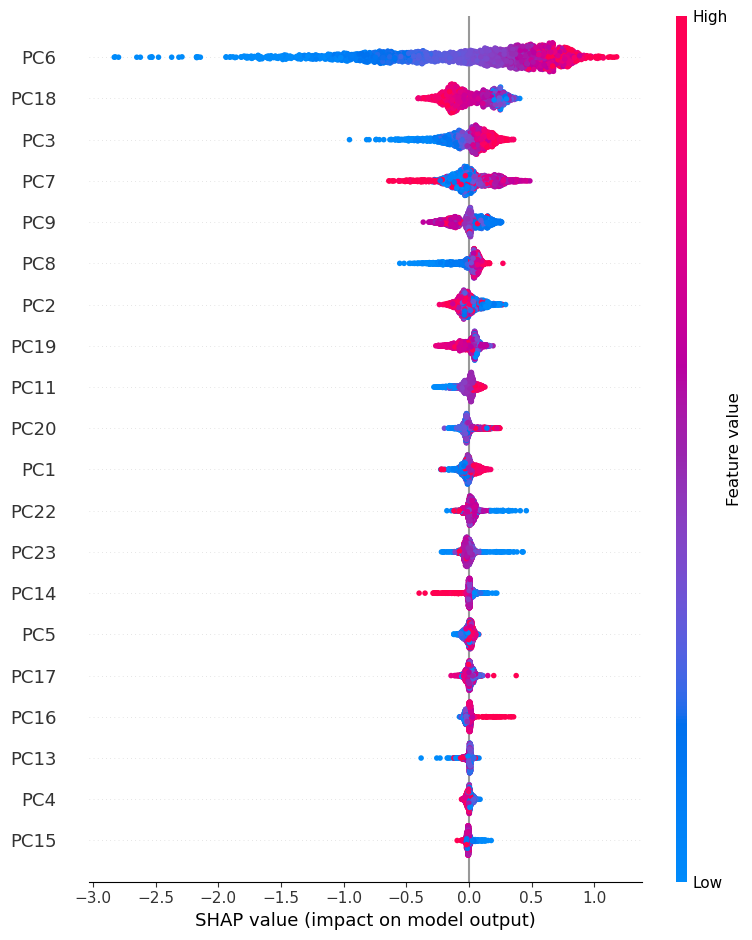

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


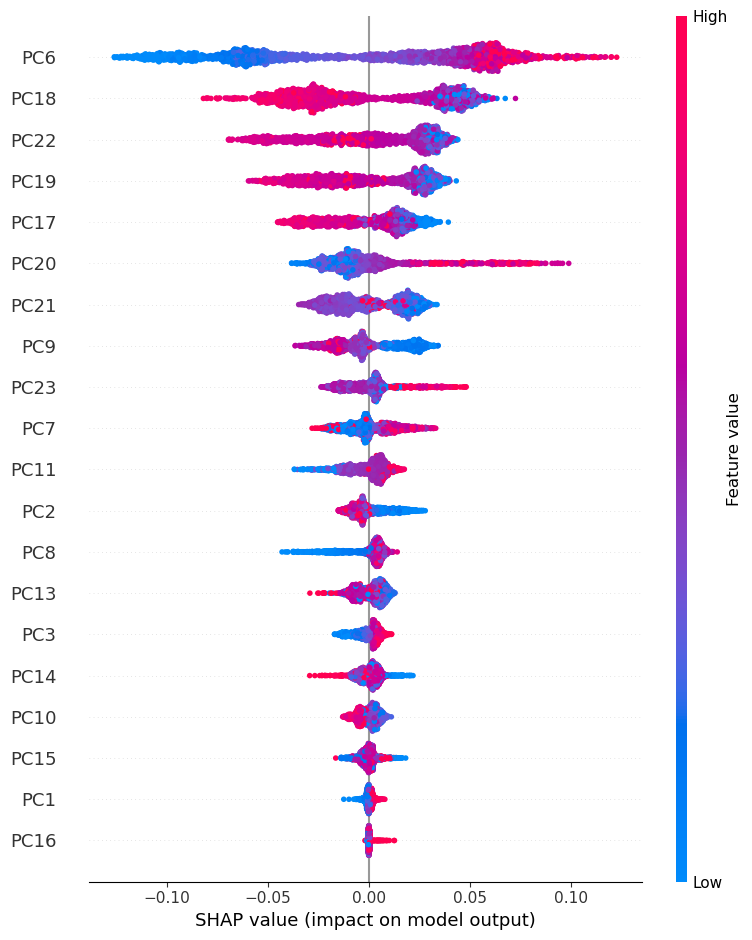

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


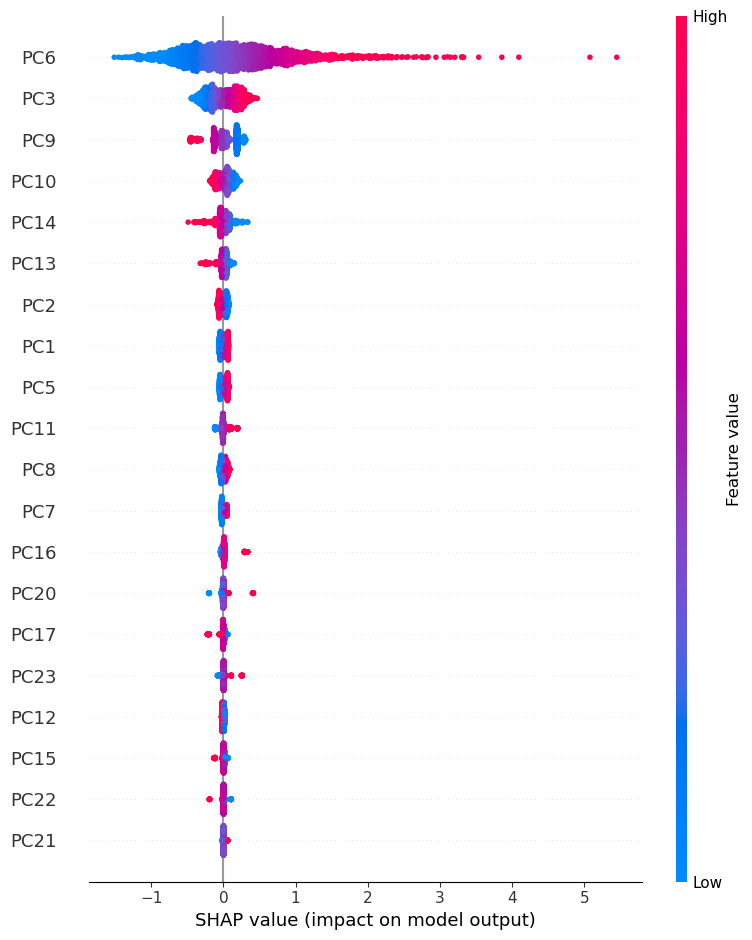

In [26]:
sample_size = 2000  # Adjust based on your memory and computation limits
X_test_sample = X_test[np.random.choice(X_test.shape[0], sample_size, replace=False), :]

# XGBoost SHAP values
explainer_xgb = shap.TreeExplainer(xgboost)
shap_values_xgb = explainer_xgb.shap_values(X_test_sample)

# Random Forest SHAP values
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test_sample)

# Logistic Regression SHAP values using LinearExplainer
explainer_logreg = shap.LinearExplainer(logreg, X_train)
shap_values_logreg = explainer_logreg.shap_values(X_test_sample)

# Visualize SHAP values for XGBoost
shap.summary_plot(shap_values_xgb, X_test_sample, feature_names=[f'PC{i+1}' for i in range(X_test.shape[1])])

# Visualize SHAP values for Random Forest
shap.summary_plot(shap_values_rf[1], X_test_sample, feature_names=[f'PC{i+1}' for i in range(X_test.shape[1])])

# Visualize SHAP values for Logistic Regression
shap.summary_plot(shap_values_logreg, X_test_sample, feature_names=[f'PC{i+1}' for i in range(X_test.shape[1])])

Hour_cos                                  0.139531
Weekday_cos                               0.069439
AggregatedPropertyCategory_Residential    0.044716
CellEastingNorthing2500_532500-180000     0.033346
CellEastingNorthing2500_527500-180000     0.023662
                                            ...   
Month_sin                                -0.032011
AggregatedPropertyCategory_Outdoor       -0.034862
IncidentGroup_Fire                       -0.045164
Month_cos                                -0.283049
DistanceStationLog                       -0.939440
Name: PC6, Length: 319, dtype: float64


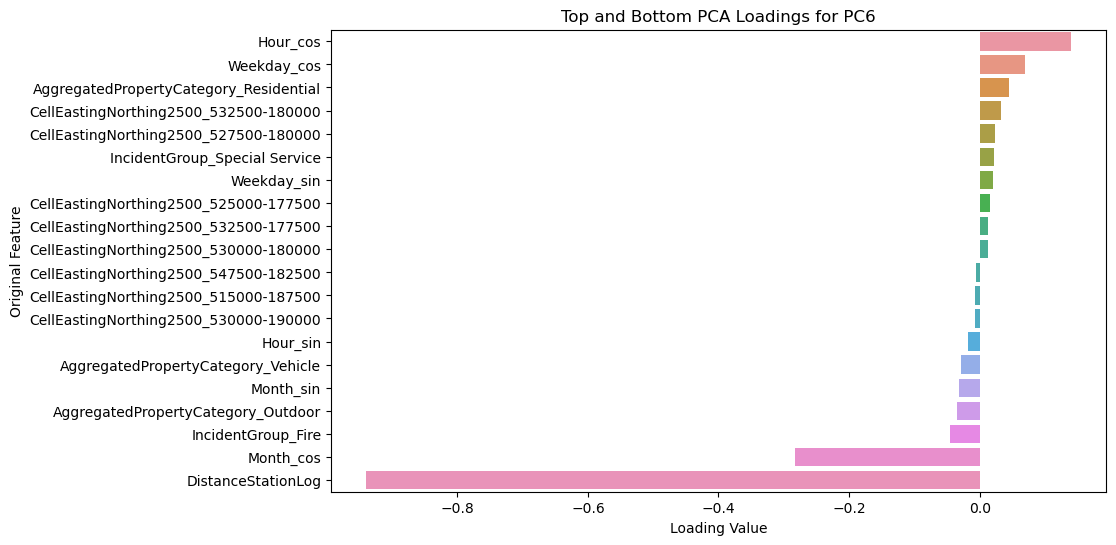

In [28]:
X = df.drop("ResponseTimeBinary", axis=1)

# Fit PCA
pca = PCA(n_components=0.85)
pca.fit(X)

# Get the loadings
loadings = pca.components_.T  # Transpose to get the correct shape

# Create a DataFrame for easier interpretation
loadings_df = pd.DataFrame(loadings, index=X.columns, columns=[f'PC{i+1}' for i in range(loadings.shape[1])])

# Display the loadings for PC6
pc6_loadings = loadings_df['PC6'].sort_values(ascending=False)
print(pc6_loadings)

# Plot the loadings for PC6
top_n = 10  # Number of top and bottom features to display
pc6_loadings_top_bottom = pd.concat([pc6_loadings.head(top_n), pc6_loadings.tail(top_n)])

plt.figure(figsize=(10, 6))
sns.barplot(x=pc6_loadings_top_bottom.values, y=pc6_loadings_top_bottom.index)
plt.title('Top and Bottom PCA Loadings for PC6')
plt.xlabel('Loading Value')
plt.ylabel('Original Feature')
plt.show()

CellEastingNorthing2500_525000-180000    0.939980
CellEastingNorthing2500_532500-180000    0.079736
CellEastingNorthing2500_530000-180000    0.028258
CellEastingNorthing2500_527500-180000    0.017455
IncidentGroup_Special Service            0.007674
                                           ...   
CellEastingNorthing2500_522500-180000   -0.032105
CellEastingNorthing2500_530000-182500   -0.046866
CellEastingNorthing2500_527500-177500   -0.104454
CellEastingNorthing2500_525000-177500   -0.126639
CellEastingNorthing2500_532500-182500   -0.269969
Name: PC18, Length: 319, dtype: float64


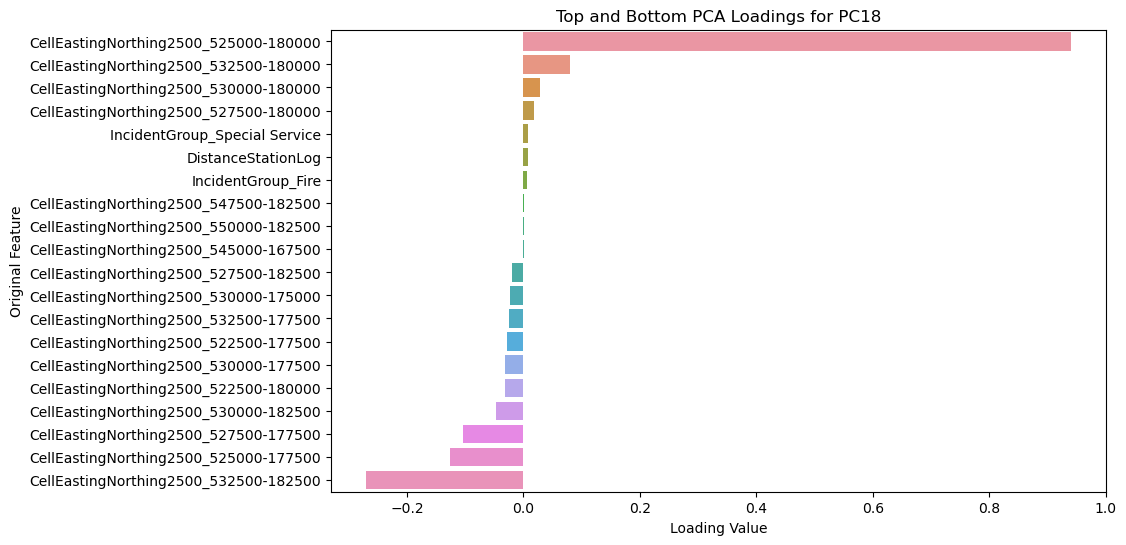

In [51]:
# Display the loadings for PC18
pc18_loadings = loadings_df['PC18'].sort_values(ascending=False)
print(pc18_loadings)

# Plot the loadings for PC18
pc18_loadings_top_bottom = pd.concat([pc18_loadings.head(top_n), pc18_loadings.tail(top_n)])

plt.figure(figsize=(10, 6))
sns.barplot(x=pc18_loadings_top_bottom.values, y=pc18_loadings_top_bottom.index)
plt.title('Top and Bottom PCA Loadings for PC18')
plt.xlabel('Loading Value')
plt.ylabel('Original Feature')
plt.show()

In [38]:
explained_variance = pca.explained_variance_ratio_
num_components

23

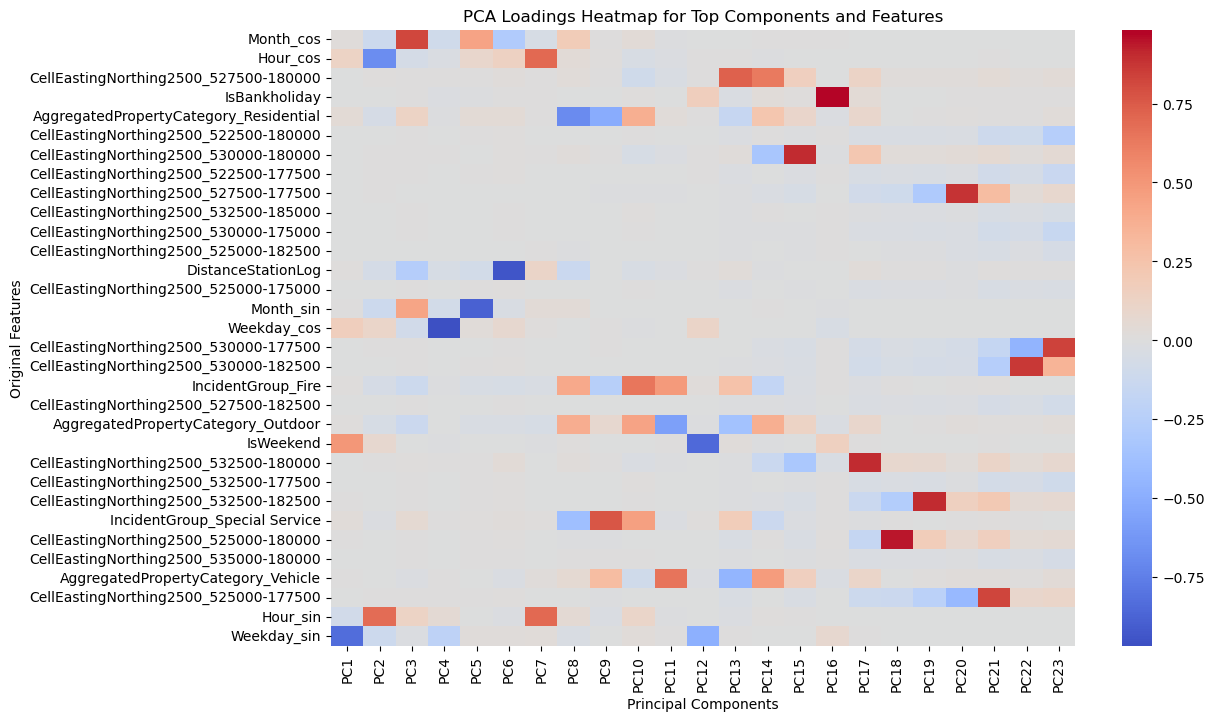

In [39]:
explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)
num_components = np.argmax(cumulative_variance >= 0.85) + 1

top_loadings_df = loadings_df.iloc[:, :num_components]
num_top_features_per_pc = 15  # Adjust based on desired number of features
overall_top_features = set()

for pc in top_loadings_df.columns:
    top_features = top_loadings_df[pc].abs().nlargest(num_top_features_per_pc).index
    overall_top_features.update(top_features)

overall_top_features = list(overall_top_features)
filtered_loadings_df = top_loadings_df.loc[overall_top_features]

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_loadings_df, cmap='coolwarm', center=0)
plt.title('PCA Loadings Heatmap for Top Components and Features')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()